# Mini Project: **Netflix Data Analysis**


In [3]:
# Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
sns.set_style('whitegrid')

# For reproducibility
np.random.seed(42)


In [4]:
# Load dataset from URL
url = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv"
df = pd.read_csv(url)
print("Dataset shape:", df.shape)
df.head(5)

Dataset shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Data Cleaning & Preprocessing

In [5]:
# Data cleaning steps
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
# Fix 'description s1' header if necessary
if 'description_s1' in df.columns:
    df = df.rename(columns={'description_s1':'description'})

# date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# extract added year/month
df['added_year'] = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month
df['added_monthname'] = df['date_added'].dt.month_name()

# fill missing meta
for col in ['director','cast','country','rating']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# duration parsing: create duration_minutes and seasons columns
def parse_duration(x):
    if pd.isna(x):
        return (np.nan, np.nan)
    if 'min' in str(x):
        try:
            mins = int(str(x).strip().split(' ')[0])
            return (mins, np.nan)
        except:
            return (np.nan, np.nan)
    if 'Season' in str(x) or 'Seasons' in str(x) or 'season' in str(x).lower():
        try:
            seasons = int(str(x).strip().split(' ')[0])
            return (np.nan, seasons)
        except:
            return (np.nan, np.nan)
    # fallback: try numeric
    try:
        v = int(''.join([ch for ch in str(x) if ch.isdigit()]))
        return (v, np.nan)
    except:
        return (np.nan, np.nan)

parsed = df['duration'].apply(parse_duration)
df['duration_minutes'] = parsed.apply(lambda t: t[0])
df['seasons'] = parsed.apply(lambda t: t[1])

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,added_year,added_month,added_monthname,duration_minutes,seasons
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,9.0,September,90.0,NaN
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,9.0,September,NaN,2.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,9.0,September,NaN,1.0


---
# Analysis & Answers to Business Questions


In [6]:
# Q1: Ratio of Movies vs TV Shows
counts = df['type'].value_counts()
counts

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

**Insight (Q1):**  
The counts above show the balance between Movies and TV Shows on Netflix. If movies vastly outnumber TV shows (or vice versa), Netflix can decide whether to increase investment in the underrepresented format depending on strategic goals (retention vs. acquisition).

In [7]:
# Q2: Top genres globally (by appearances in 'listed_in')
# 'listed_in' can contain multiple genres separated by comma
from collections import Counter
genre_series = df['listed_in'].dropna().str.split(',').explode().str.strip()
genre_counts = genre_series.value_counts().head(20)
genre_counts

listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
TV Comedies                  581
Thrillers                    577
Crime TV Shows               470
Kids' TV                     451
Docuseries                   395
Music & Musicals             375
Romantic TV Shows            370
Horror Movies                357
Stand-Up Comedy              343
Reality TV                   255
Name: count, dtype: int64

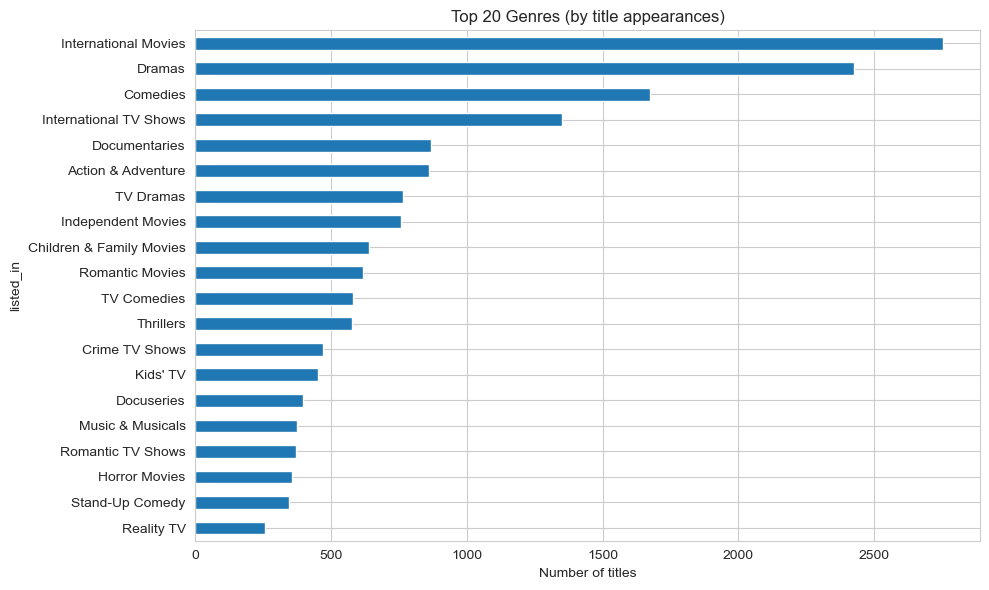

In [8]:
# Plot top genres
plt.figure(figsize=(10,6))
genre_counts.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Genres (by title appearances)')
plt.xlabel('Number of titles')
plt.tight_layout()
plt.show()

**Insight (Q2):**  
Top genres highlight content categories Netflix should continue to invest in. Pair this with performance/engagement metrics (if available) to prioritize.


In [9]:
# Q3: Which years saw the highest release of content (release_year)
top_years = df['release_year'].value_counts().sort_index()
top_years.tail(10)

release_year
2012     237
2013     288
2014     352
2015     560
2016     902
2017    1032
2018    1147
2019    1030
2020     953
2021     592
Name: count, dtype: int64

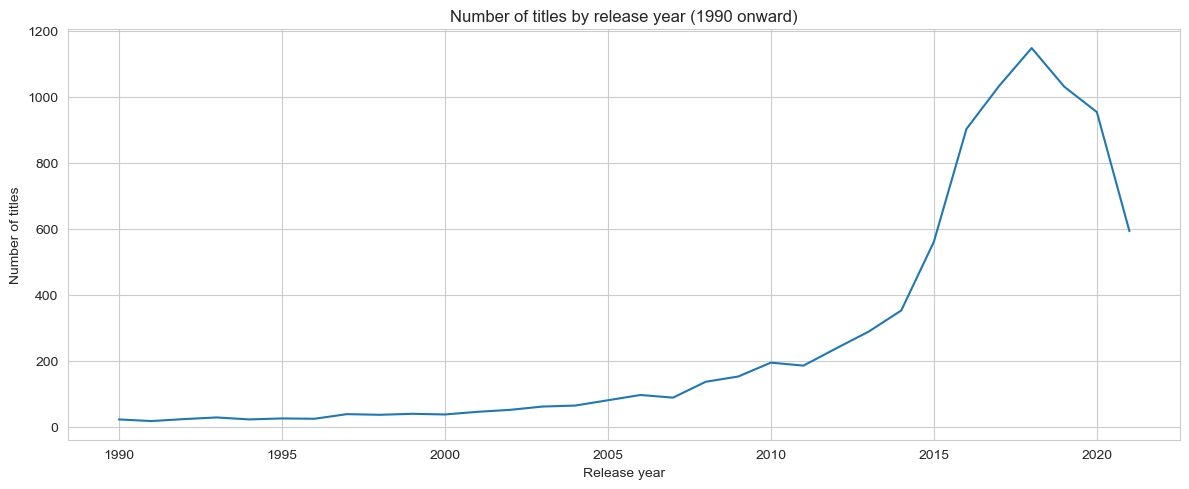

In [10]:
# Plot releases by year (last 30 years)
plt.figure(figsize=(12,5))
top_years.loc[top_years.index>=1990].plot()
plt.title('Number of titles by release year (1990 onward)')
plt.xlabel('Release year')
plt.ylabel('Number of titles')
plt.tight_layout()
plt.show()

**Insight (Q3):**  
Peaks in release counts may correspond to active acquisition/production phases. Observe the trend to estimate whether Netflix is increasingly acquiring newer content.


In [11]:
# Q4: Which countries produce the most Netflix content?
country_series = df['country'].dropna().str.split(',').explode().str.strip()
country_counts = country_series.value_counts().head(20)
country_counts

country
United States     3690
India             1046
Unknown            831
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
China              162
Australia          160
Egypt              117
Turkey             113
Hong Kong          105
Nigeria            103
Italy              100
Brazil              97
Argentina           91
Name: count, dtype: int64

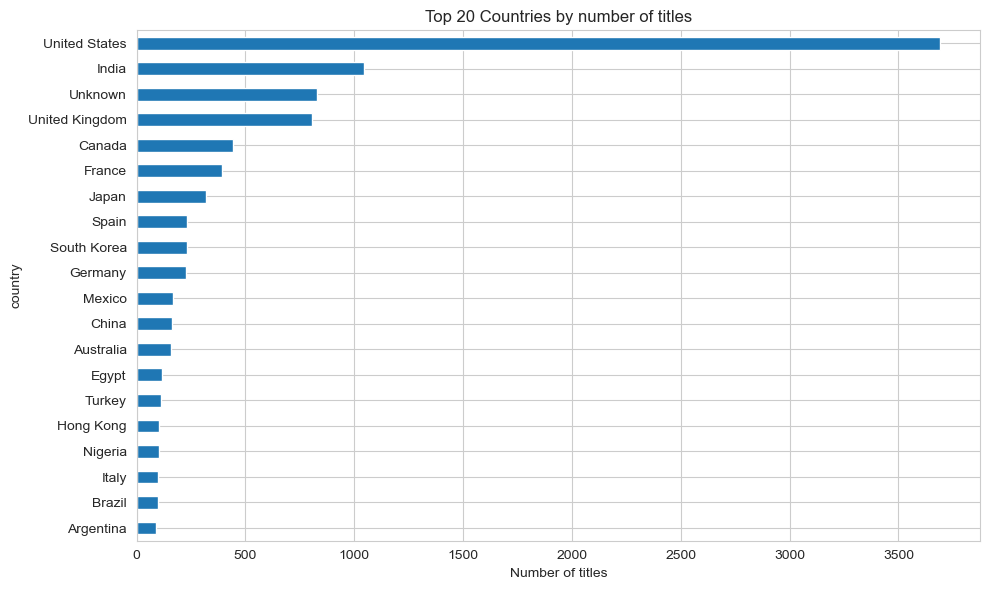

In [12]:
plt.figure(figsize=(10,6))
country_counts.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Countries by number of titles')
plt.xlabel('Number of titles')
plt.tight_layout()
plt.show()

**Insight (Q4):**  
Top producing countries indicate where local content partnerships and investments already exist — prioritise countries with growing production and high subscriber potential.


In [13]:
# Q6: Most frequent ratings
if 'rating' in df.columns:
    rating_counts = df['rating'].value_counts().head(20)
    rating_counts
else:
    print("No rating column found")

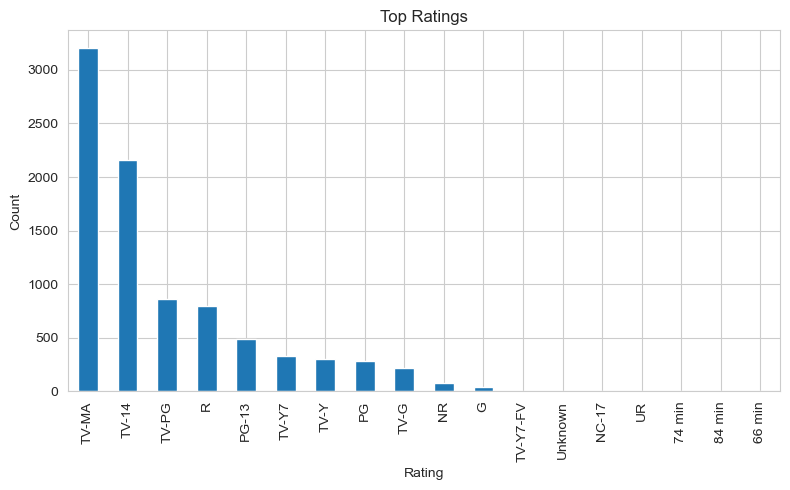

In [14]:
plt.figure(figsize=(8,5))
rating_counts.plot(kind='bar')
plt.title('Top Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Insight (Q6):**  
The distribution of ratings helps Netflix target age groups and determine whether to expand family-friendly vs mature content.


In [15]:
# Q11: Top 10 directors with the most Netflix titles
# directors field may contain multiple names; split and count
director_series = df['director'].dropna().replace('', 'Unknown').str.split(',').explode().str.strip()
director_counts = director_series.value_counts().head(15)
director_counts

director
Unknown                2634
Rajiv Chilaka            22
Jan Suter                21
Raúl Campos              19
Suhas Kadav              16
Marcus Raboy             16
Jay Karas                15
Cathy Garcia-Molina      13
Martin Scorsese          12
Jay Chapman              12
Youssef Chahine          12
Steven Spielberg         11
Don Michael Paul         10
Yılmaz Erdoğan            9
David Dhawan              9
Name: count, dtype: int64

**Insight (Q11):**  
Identifying prolific directors helps shape partnership and acquisition strategies. Approach top directors for future collaboration or licensing deals.


In [16]:
# Q12: Top actors (cast)
cast_series = df['cast'].dropna().replace('', 'Unknown').str.split(',').explode().str.strip()
cast_counts = cast_series.value_counts().head(20)
cast_counts

cast
Unknown              825
Anupam Kher           43
Shah Rukh Khan        35
Julie Tejwani         33
Naseeruddin Shah      32
Takahiro Sakurai      32
Rupa Bhimani          31
Akshay Kumar          30
Om Puri               30
Yuki Kaji             29
Amitabh Bachchan      28
Paresh Rawal          28
Boman Irani           27
Vincent Tong          26
Rajesh Kava           26
Kareena Kapoor        25
Andrea Libman         25
John Cleese           24
Samuel L. Jackson     24
Jigna Bhardwaj        23
Name: count, dtype: int64

**Insight (Q12):**  
Frequent actors may bring viewership loyalty. Focus marketing or production efforts around talent with high presence in the catalogue.


In [17]:
# Q15: Average duration of Movies
movie_minutes = df[df['type']=='Movie']['duration_minutes']
movie_minutes.describe()

count    6128.000000
mean       99.577187
std        28.290593
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration_minutes, dtype: float64

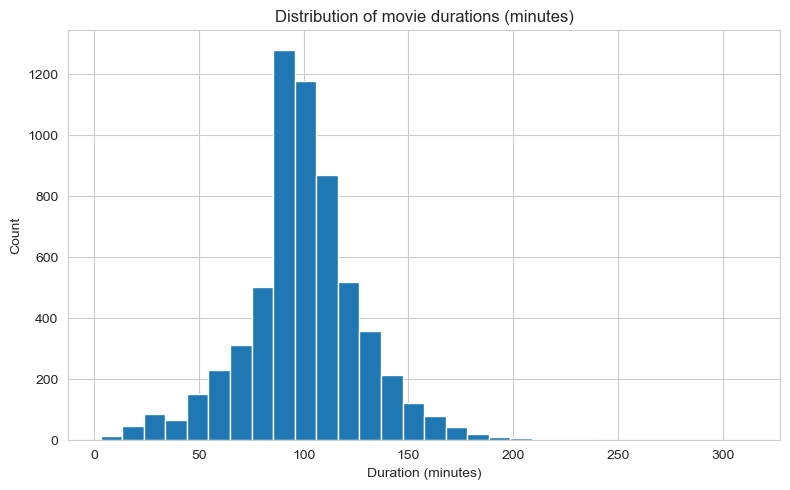

In [18]:
plt.figure(figsize=(8,5))
movie_minutes.dropna().hist(bins=30)
plt.title('Distribution of movie durations (minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Insight (Q15):**  
Average movie duration gives guidance on optimal content length. If most popular or common movies cluster around 90-120 minutes, that can be considered a baseline for acquisitions.


In [19]:
# Q18: In which months does Netflix add the most content?
added_month_counts = df['added_monthname'].value_counts().reindex(
    ['January','February','March','April','May','June','July','August','September','October','November','December']
).fillna(0)
added_month_counts

added_monthname
January      727
February     557
March        734
April        759
May          626
June         724
July         819
August       749
September    765
October      755
November     697
December     797
Name: count, dtype: int64

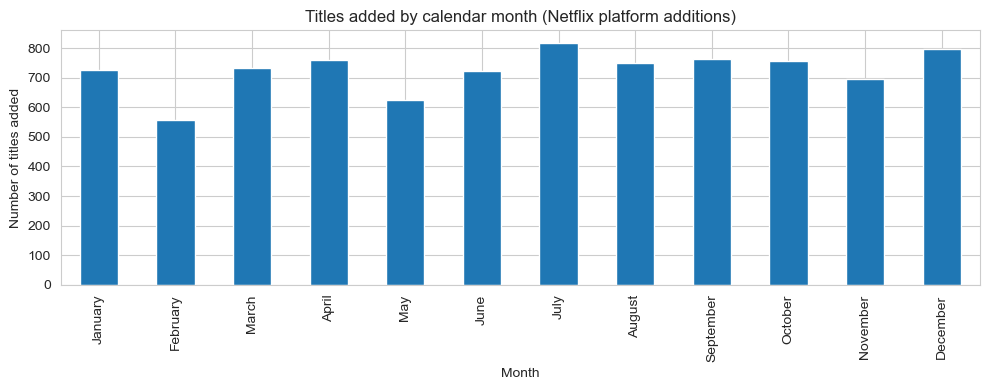

In [20]:
plt.figure(figsize=(10,4))
added_month_counts.plot(kind='bar')
plt.title('Titles added by calendar month (Netflix platform additions)')
plt.xlabel('Month')
plt.ylabel('Number of titles added')
plt.tight_layout()
plt.show()

**Insight (Q18):**  
Peak months for additions suggest ideal windows for marketing pushes and new release calendars.
